### Tank level control with Deep Deterministic Policy Gradient

Based on the code of Alex Kummer PhD

#### Importing libraries

In [1]:
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
import random
from collections import deque
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch as T
import os
import gym
import matplotlib.pyplot as plt
import timeit

#### 1.0 Tank class

In [2]:
class Tank:
    '''
    A class for the tank model
    '''
    def __init__(self, height, h0, h_max, h_min, r_tank, pipe_r, SP):
        self.height      = height              #m
        self.init_level  = h0                  #m
        self.max_level   = h_max               #m
        self.min_level   = h_min               #m
        self.radius      = r_tank              #m
        self.pipe_radius = pipe_r              #m
        self.A           = r_tank**2*math.pi   #m^2
        self.A_pipe      = pipe_r**2*math.pi   #m^2
        self.V           = self.A * self.height #m^3
        self.SP          = SP                   #m
    
    def get_dhdt(self,h,t, q_in, valve_opening):
        '''
        Calculates the dynamics of the liquid level change in the tank
        '''
        if h > 0:
            q_out = valve_opening*(self.A_pipe*((2*9.81*h)**0.5))
        else:
            q_out = 0
        
        dhdt = (q_in - q_out)/self.A
        
        if h >= self.max_level and dhdt > 0:
            dhdt = 0
        
        return dhdt
    
    def get_level_dynamics(self, time, vol_flow_in, valve_opening, h0):
        z = np.zeros(len(time))
        
        for i in range(len(time)-1):
            pct_opened = valve_opening
            q_in = vol_flow_in[i+1]
            y = odeint(self.get_dhdt, h0, [0,1], args = (q_in, pct_opened))
            h0 = y[-1]
            z[i+1] = h0
            
        return z
        

#### 2.0 Environment class

In [3]:
class Environment:
    def __init__(self,tank):
        self.tank_height = tank.height           
        self.init_level  = tank.init_level             
        self.max_level   = tank.max_level             
        self.min_level   = tank.min_level               
        self.radius      = tank.radius              
        self.pipe_radius = tank.pipe_radius           
        self.A           = tank.A
        self.A_pipe      = tank.A_pipe
        self.terminated  = False
        self.state_space_size = (2,)
        self.SP          = tank.SP
        self.tank        = tank

        
    def step(self,level,vol_f, next_vol_f, action):
        '''
        Calculates the liquid level change in the tank based on the inlet volume flow, the actual liquid level and the valve opening,
        returns the observation [level, level change, inlet volume flow, reward, if done]
        '''
        h0     = level
        q_in   = vol_f
        pct_opened = action
        y = odeint(self.tank.get_dhdt, h0, [0,0.1], args = (q_in, pct_opened))
        new_level = float(y[-1])
        level_change = h0 - new_level
        new_vol_f = next_vol_f
        new_state = [new_level, level_change, new_vol_f]
        reward    = self.get_reward_new(new_level)
        done      = self.is_terminate_state(new_level)
        
        return new_state, reward, done
    
    def is_terminate_state(self, state):
        '''
        Checks if the current liquid level is a terminal state or not
        '''
        if state <= self.min_level or state >= self.max_level:
            return True
        else:
            return False
        
    def get_reward(self, state):
        '''
        If the level is close to the defined set point the function returns 10,
        if reaches the minimal or maximal levels returns -5,
        otherwise returns 0 
        '''
        if state > self.max_level or state < self.min_level:
            return -5
        elif state < (1.01*self.SP) and state > (0.99*self.SP):
            return 10
        else:
            return 0
        
    def get_reward_new(self, state):
        if state > self.max_level or state < self.min_level:
            return -10
        else:
            return -(state - self.SP)**2    
        
    def get_inlet_flow(self, iterations):
        ''' 
        Creates a numpy array containing the tank's inlet volume flow distrubed with gaussian noise
        '''
        sigma = 1
        vol_f = np.array([])
        q_init = 4
        for i in range(0,iterations):
            q_init  = abs(np.random.normal(q_init, 0.005*sigma))
            vol_f = np.append(vol_f, q_init)
        return vol_f

        
    def reset(self):
        '''
        Resets the environment to a random state
        '''
        state = np.zeros(3,)
        state[0] = np.random.uniform(3,5)
        state[2] = self.get_inlet_flow(1)[0] 
        return state
        

In [5]:
class NormalActionNoise():
    def __init__(self, mu=0, sigma=0.15):
        self.mu = mu
        self.sigma = sigma
    def __call__(self):
        noise = np.random.normal(loc=self.mu, scale=self.sigma)
        return  noise

    def exploration_decay(self):
        if self.sigma <= 0.2:
            return
        self.sigma -= 0.0025

#### 3.0 Replay buffer class

In [8]:
class ReplayBuffer():
    def __init__(self, max_size, input_shape, n_actions):
        self.memory_size      = max_size
        self.memory_lenght    = 0
        self.state_memory     = np.zeros((self.memory_size, *input_shape), dtype=np.float32)
        self.new_state_memory = np.zeros((self.memory_size, *input_shape), dtype=np.float32)
        self.action_memory    = np.zeros((self.memory_size), dtype=np.float32)
        self.reward_memory    = np.zeros((self.memory_size), dtype=np.float32)
        self.terminal_memory  = np.zeros((self.memory_size), dtype=np.int64)

    def store_transition(self, state, action, reward, state_, done):
        index = self.memory_lenght % self.memory_size
        self.state_memory[index]     = state
        self.new_state_memory[index] = state_
        self.action_memory[index]    = action
        self.reward_memory[index]    = reward
        self.terminal_memory[index]  = done
        self.memory_lenght          += 1

    def sample_buffer(self, batch_size):
        max_memory = min(self.memory_lenght, self.memory_size)
        batch = np.random.choice(max_memory, batch_size, replace=False)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, states_, dones

#### 4.0 Actor and critic neural networks

##### 4.1 Critic network

In [7]:
class CriticNetwork(nn.Module):
    def __init__(self, beta, input_dims, hidden_layers, fc1_dims, fc2_dims, n_actions, name,
                 chkpt_dir=r'C:\Users\AroSomogyi\Documents\DDPG\New_reward_function'):
        super(CriticNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name + '_ddpg')
        self.hidden_layers = hidden_layers

        if self.hidden_layers == 1:
            self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)

            # Divergence from the paper
            self.bn1 = nn.LayerNorm(self.fc1_dims)

            self.action_value = nn.Linear(self.n_actions, self.fc1_dims)
            self.q = nn.Linear(self.fc1_dims, 1)
        elif self.hidden_layers == 2:
            self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
            self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)

            #Divergence from the paper
            self.bn1 = nn.LayerNorm(self.fc1_dims)
            self.bn2 = nn.LayerNorm(self.fc2_dims)

            self.action_value = nn.Linear(self.n_actions, self.fc2_dims)
            self.q = nn.Linear(self.fc2_dims, 1)

        self.optimizer = optim.Adam(self.parameters(), lr=beta, weight_decay=0.01)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        # self.device = T.device('cpu')
        self.to(self.device)

    def forward(self, state, action):
        if self.hidden_layers == 1:
            state_value = self.fc1(state)
            state_value = self.bn1(state_value)
            state_value = F.relu(state_value)
            action_value = self.action_value(action)
            state_action_value = F.relu(T.add(state_value, action_value))
            state_action_value = self.q(state_action_value)

        elif self.hidden_layers == 2:
            state_value = self.fc1(state)
            state_value = self.bn1(state_value)
            state_value = F.relu(state_value)
            state_value = self.fc2(state_value)
            state_value = self.bn2(state_value)
            action_value = self.action_value(action)
            state_action_value = F.relu(T.add(state_value, action_value))
            state_action_value = self.q(state_action_value)

        return state_action_value

    def save_checkpoint(self):
        print( '... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print( '... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))


##### 4.2 Actor network

In [6]:
class ActorNetwork(nn.Module):
    def __init__(self, alpha, input_dims, hidden_layers, fc1_dims, fc2_dims, action_interval,
                 n_actions, name, chkpt_dir= r'C:\Users\AroSomogyi\Documents\DDPG\New_reward_function'):
        super(ActorNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name + '_ddpg')
        self.hidden_layers = hidden_layers
        self.action_interval = action_interval

        if self.hidden_layers == 1:
            self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
            self.bn1 = nn.LayerNorm(self.fc1_dims)

            # batch norm: self.bn1 = nn.BatchNorm1d(self.fc1_dims), self.bn2 = nn.BatchNorm1d(self.fc2_dims)

            self.mu = nn.Linear(self.fc1_dims, self.n_actions)

        elif self.hidden_layers == 2:
            self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
            self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)

            self.bn1 = nn.LayerNorm(self.fc1_dims)
            self.bn2 = nn.LayerNorm(self.fc2_dims)

            #batch norm: self.bn1 = nn.BatchNorm1d(self.fc1_dims), self.bn2 = nn.BatchNorm1d(self.fc2_dims)

            self.mu = nn.Linear(self.fc2_dims, self.n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        # self.device = T.device('cpu')

        self.to(self.device)

    def forward(self, state):
        if self.hidden_layers == 1:
            x = self.fc1(state)
            x = self.bn1(x)
            x = F.relu(x)
            x = T.sigmoid(self.mu(
                x)) * self.action_interval  # if the action range is not -1, +1 then you can change the boundaries here, like *2 --> [-2, +2], etc.

        elif self.hidden_layers == 2:
            x = self.fc1(state)
            x = self.bn1(x)
            x = F.relu(x)
            x = self.fc2(x)
            x = self.bn2(x)
            x = F.relu(x)
            x = T.sigmoid(self.mu(x))*self.action_interval   #if the action range is not -1, +1 then you can change the boundaries here, like *2 --> [-2, +2], etc.

        return x

    def save_checkpoint(self):
        print('~ New optim found, saving model ~')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('~ Loading saved NN parameters ~')
        self.load_state_dict(T.load(self.checkpoint_file))

#### 5.0 DDPG agent 

In [5]:
class DDPG_Agent:
    def __init__(self, alpha, beta, input_dims, tau, n_actions, gamma=0.99,
                 max_size = 1_000_000, hidden_layers = 2, action_interval=10, fc1_dims=400, fc2_dims=300,
                 batch_size=64, name='1'):
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        self.alpha = alpha
        self.beta = beta
        self.name = name

        self.memory = ReplayBuffer(max_size, input_dims, n_actions)

        # self.noise = OUActionNoise(mu=np.zeros(n_actions))
        self.noise = NormalActionNoise(mu=0, sigma=0.015)

        self.actor = ActorNetwork(alpha, input_dims, hidden_layers, fc1_dims, fc2_dims, action_interval,
                                  n_actions=n_actions, name='actor_' + self.name)
        self.critic = CriticNetwork(beta, input_dims, hidden_layers, fc1_dims, fc2_dims,
                                    n_actions=n_actions, name='critic_' + self.name)
        self.target_actor = ActorNetwork(alpha, input_dims, hidden_layers, fc1_dims, fc2_dims, action_interval,
                                  n_actions=n_actions, name='target_actor_' + self.name)
        self.target_critic = CriticNetwork(beta, input_dims, hidden_layers, fc1_dims, fc2_dims,
                                    n_actions=n_actions, name='target_critic_' + self.name)

        self.update_network_parameters(tau=1)

    def choose_action(self, observation):

        self.actor.eval() #To turn off the batchnorm layer in evaluation mode, only necessary in training mode, so it does not calculate statistics
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)
        mu = self.actor.forward(state).to(self.actor.device)
        #Exploration:


        mu_prime = mu + T.tensor(self.noise(), dtype=T.float).to(self.actor.device)


        # mu_prime = mu
        self.actor.train() # to turn on the batchnorm layer in training mode
        return mu.cpu().detach().numpy()[0]
    
    def action_mapper(self, action):
        action_value = action * 100
        return action_value


    def remember(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def save_models(self):
        self.actor.save_checkpoint()
        self.target_actor.save_checkpoint()
        self.critic.save_checkpoint()
        self.target_critic.save_checkpoint()

    def load_models(self):
        self.actor.load_checkpoint()
        self.target_actor.load_checkpoint()
        self.critic.load_checkpoint()
        self.target_critic.load_checkpoint()


    def learn(self):
        if self.memory.memory_lenght < self.batch_size:
            return

        states, actions, rewards, states_, done = self.memory.sample_buffer(self.batch_size)

        states = T.tensor(states, dtype=T.float).to(self.actor.device)
        states_ = T.tensor(states_, dtype=T.float).to(self.actor.device)
        actions = T.tensor(actions, dtype=T.float).to(self.actor.device)
        actions = actions.view(self.batch_size,1)
        rewards = T.tensor(rewards, dtype=T.float).to(self.actor.device)
        done = T.tensor(done).to(self.actor.device)

        target_actions = self.target_actor.forward(states_)
        critic_value_ = self.target_critic.forward(states_, target_actions) #Q value of the next evaluation - critic
        critic_value = self.critic.forward(states, actions) #actual prediction of Q-value - critic

        critic_value_[done] = 0.0
        critic_value_ = critic_value_.view(-1)

        target = rewards + self.gamma*critic_value_ #y_i   # target value
        target = target.view(self.batch_size, 1)

        self.critic.optimizer.zero_grad()
        critic_loss = F.mse_loss(target, critic_value)
        critic_loss.backward()
        self.critic.optimizer.step()

        self.actor.optimizer.zero_grad()
        actor_loss = -self.critic.forward(states, self.actor.forward(states)) #Q values in states based on the critic network
        actor_loss = T.mean(actor_loss) #Average loss function
        actor_loss.backward()
        self.actor.optimizer.step()

        self.update_network_parameters()

    def update_network_parameters(self, tau=None): #soft-update
        if tau is None:
            tau = self.tau
        actor_params = self.actor.named_parameters()
        critic_params = self.critic.named_parameters()
        target_actor_params = self.target_actor.named_parameters()
        target_critic_params = self.target_critic.named_parameters()

        critic_state_dict = dict(critic_params)
        actor_state_dict = dict(actor_params)
        target_critic_state_dict = dict(target_critic_params)
        target_actor_state_dict = dict(target_actor_params)

        for name in critic_state_dict:
            critic_state_dict[name] = tau*critic_state_dict[name].clone() + \
                                      (1-tau)*target_critic_state_dict[name].clone()

        for name in actor_state_dict:
            actor_state_dict[name] = tau * actor_state_dict[name].clone() + \
                                      (1 - tau) * target_actor_state_dict[name].clone()

        self.target_critic.load_state_dict(critic_state_dict)
        self.target_actor.load_state_dict(actor_state_dict)


#### 6.0 Creating inlet volume flows for training

In [10]:
agent = DDPG_Agent(alpha=0.000025, beta=0.00025, input_dims=(3,),
                   tau = 0.001, n_actions=1, gamma=0.99, max_size=100_000, hidden_layers=2, action_interval=1,
                   fc1_dims=400, fc2_dims=300, batch_size=64, name='Tank_level_DDPG')

In [11]:
vol_f = env.get_inlet_flow(600_000)
vol_f

array([3.00019302, 2.9905919 , 2.99088923, ..., 0.90419681, 0.90230288,
       0.8961245 ])

In [12]:
vol_f = np.append(vol_f, vol_f)

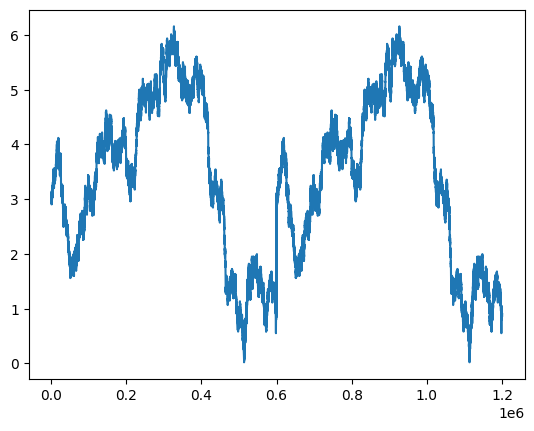

In [13]:
plt.plot(vol_f)

#### 7.0 DDPG agent training

Time:  0.022699099999954342
episode 0 score:  -5 average score -5.0 best score -inf
~ New optim found, saving model ~
~ New optim found, saving model ~
... saving checkpoint ...
... saving checkpoint ...
Time:  0.01924739999958547
episode 1 score:  -5 average score -5.0 best score -5.0
Time:  0.09174119999988761
episode 2 score:  5 average score -1.7 best score -5.0
~ New optim found, saving model ~
~ New optim found, saving model ~
... saving checkpoint ...
... saving checkpoint ...
Time:  0.23564299999998184
episode 3 score:  -5 average score -2.5 best score -1.7
Time:  0.21470640000006824
episode 4 score:  5 average score -1.0 best score -1.7
~ New optim found, saving model ~
~ New optim found, saving model ~
... saving checkpoint ...
... saving checkpoint ...
Time:  1.6841418999993039
episode 5 score:  15 average score 1.7 best score -1.0
~ New optim found, saving model ~
~ New optim found, saving model ~
... saving checkpoint ...
... saving checkpoint ...
Time:  0.6067120999996405

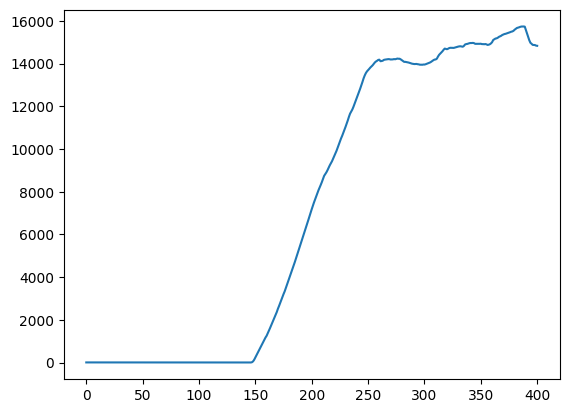

In [25]:
tank = Tank(height = 8, h0 = 0.0, h_max = 7, h_min = 0.5, r_tank = 1.5, pipe_r =0.1, SP = 4)
env = Environment(tank)

agent = DDPG_Agent(alpha=0.001, beta=0.001, input_dims=(3,),
                   tau = 0.05, n_actions=1, gamma=0.99, max_size=100_000, hidden_layers=2, action_interval=1,
                   fc1_dims=300, fc2_dims=400, batch_size=128, name='Tank_level_DDPG')

best_score = -np.inf
n_cases = 500
load_checkpoint = False
h0 = 0
max_iterations = 2000
n_steps = 0

res = 100
score_history , action_list = [], []

for i in range(n_cases):
    done = False
    score = 0
    observation = env.reset()
    h0 = observation[0]
    iterations = 0
    start = timeit.default_timer()
    
    while not done:

        action = agent.choose_action(observation)
        observation_, reward, done = env.step(h0, vol_f[n_steps], vol_f[n_steps], agent.action_mapper(action))
        h0 = observation_[0]
        score += reward
        action_list.append(action)
       

        if not load_checkpoint:
            agent.remember(observation, action, reward, observation_, int(done))
            
            agent.learn()

        observation = observation_
        
        if n_steps < (len(vol_f)-1):
            n_steps += 1
        else:
            n_steps = 0
            
        iterations +=1
        if iterations >= max_iterations:
            break

    stop = timeit.default_timer()
    print('Time: ', stop - start)

    score_history.append(score)

    avg_score = np.mean(score_history[-res:])
    print('episode', i, 'score: ', score,
          'average score %.1f best score %.1f' %
          (avg_score, best_score)
          )

    if avg_score > best_score:
        if not load_checkpoint:
            agent.save_models()
        best_score = avg_score

moving_avg = np.convolve(score_history, np.ones((res,)) / res,
                                 mode='valid')
plt.plot(range(len(moving_avg)),moving_avg)

#### Moving averages of training scores

Text(0, 0.5, 'Moving average')

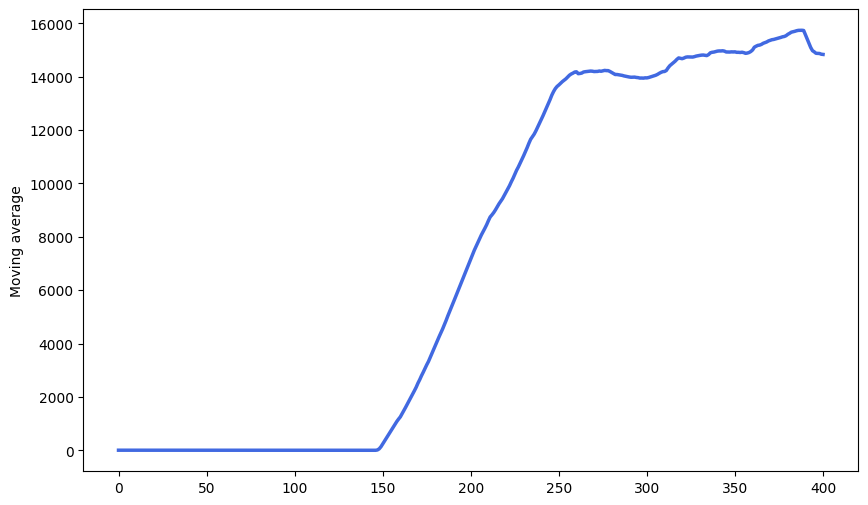

In [35]:
moving_avg = np.convolve(score_history, np.ones((res,)) / res,
                                 mode='valid')
plt.figure(figsize=(10,6))
plt.plot(range(len(moving_avg)),moving_avg, color = 'royalblue', linewidth = 2.5)
plt.ylabel('Moving average')

#### Training scores

Text(0, 0.5, 'Score')

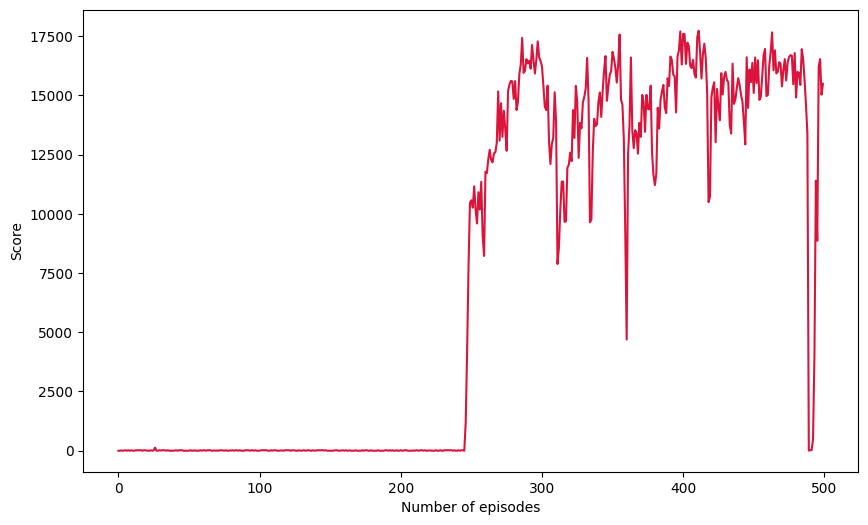

In [31]:
plt.figure(figsize=(10,6))

moving_avg = np.convolve(score_history, np.ones((res,)) / res, mode='valid')
plt.plot(range(len(score_history)),score_history, color = 'crimson')
plt.xlabel('Number of episodes')
plt.ylabel('Score')

#### 8.0 DDPG agent evaluation

In [39]:
vol_flow = env.get_inlet_flow(50_000)

In [41]:
tank = Tank(height = 8, h0 = 0.0, h_max = 7, h_min = 0.5, r_tank = 1.5, pipe_r =0.1, SP = 4)
env = Environment(tank)

agent = DDPG_Agent(alpha=0.001, beta=0.001, input_dims=(3,),
                   tau = 0.001, n_actions=1, gamma=0.99, max_size=100_000, hidden_layers=2, action_interval=1,
                   fc1_dims=300, fc2_dims=400, batch_size=128, name='Tank_level_DDPG')

best_score = -np.inf
n_cases = 1
load_checkpoint = True
h0 = 0
max_iterations = 20_000
n_steps = 0

if load_checkpoint:
    agent.load_models()

res = 100
score_array, action_array, tank_levels = [], [], []

for i in range(n_cases):
    done = False
    score = 0
    observation = env.reset()
    h0 = observation[0]
    iterations = 0
    start = timeit.default_timer()
    
    while not done:

        action = agent.choose_action(observation)
        observation_, reward, done = env.step(h0, vol_flow[n_steps], vol_flow[n_steps], agent.action_mapper(action))
        h0 = observation_[0]
        score += reward

        #Appending simulation results
        tank_levels.append(h0)
        action_array.append(action)
       

        if not load_checkpoint:
            agent.remember(observation, action, reward, observation_, int(done))
            
            agent.learn()

        observation = observation_
        
        if n_steps < (len(vol_flow)-1):
            n_steps += 1
        else:
            break

        print(score)
            

    stop = timeit.default_timer()
    print('Time: ', stop - start)

    score_array.append(score)

    avg_score = np.mean(score_history[-res:])
    print('episode', i, 'score: ', score,
          'average score %.1f best score %.1f' %
          (avg_score, best_score)
          )

    if avg_score > best_score:
        if not load_checkpoint:
            agent.save_models()
        best_score = avg_score

    iterations +=1

    if iterations == max_iterations:
            break

moving_avg2 = np.convolve(score_history, np.ones((res,)) / res,
                                 mode='valid')
plt.plot(range(len(moving_avg2)),moving_avg2)

~ Loading saved NN parameters ~
~ Loading saved NN parameters ~
... loading checkpoint ...
... loading checkpoint ...
0
0
0
0
0
0
0
0
0
0
0
0
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930

KeyboardInterrupt: 

In [42]:
new_action_array = []

for i in action_array:
    new_action_array.append(i*100)

C:\Users\AroSomogyi\AppData\Local\Temp\1\ipykernel_15516\3514609836.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,1,1)


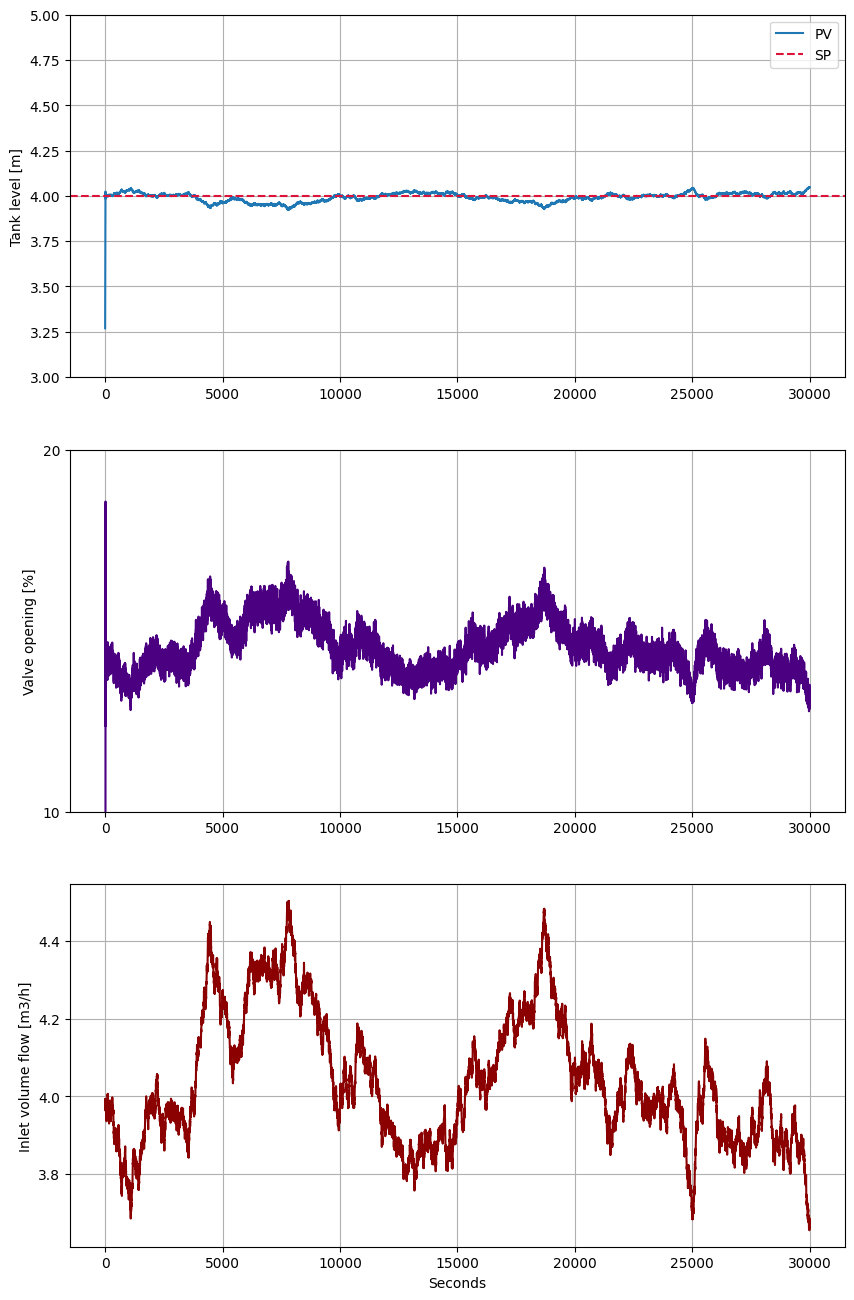

In [46]:
plt.figure(figsize = (10,16))
plt.title('Tank level control with ')
plt.subplot(3,1,1)
plt.plot(tank_levels[:30000], label = 'PV')
plt.axhline(tank.SP, color = 'crimson', linestyle = '--', label = 'SP')
plt.ylim(0,tank.height)
plt.legend()
plt.ylabel('Tank level [m]')
plt.ylim(3,5)
#plt.xlim(0,10000)
plt.grid()
plt.subplot(3,1,2)
plt.plot(new_action_array[:30000], color = 'indigo')
plt.yticks(np.arange(0,100,10))
plt.ylabel('Valve opening [%]')
plt.ylim(10,20)
plt.grid()
plt.subplot(3,1,3)
plt.plot(vol_flow[:30000], color = 'darkred')
plt.ylabel('Inlet volume flow [m3/h]')
plt.xlabel('Seconds')
plt.grid()